In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import sunpy
import sunpy.map
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from sunraster.instr.spice import read_spice_l2_fits
import h5py
from correct_2d_psf import get_fwd_matrices, correct_spice_raster
from util import bindown, as_dict, get_iris_data, masked_median_filter, get_mask_errs
from fit_spice_lines import get_overall_center, fit_spice_lines as fsl

import cmcrameri.cm as cmcm
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize)
import os
from copy import deepcopy

/home/yjzhu/Solar/spice_psf/spice_psf/util.py:37: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(fastmath=True, parallel=True)


In [2]:
spice_raster = read_spice_l2_fits("../../src/SPICE/20221022/lvl2/solo_L2_spice-n-ras_20221022T205536_V06_150995382-000.fits")

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-OBS to 59874.871951 from DATE-OBS.
Set MJD-BEG to 59874.871951 from DATE-BEG.
Set MJD-AVG to 59874.950052 from DATE-AVG.
Set MJD-END to 59875.028152 from DATE-END'. [astropy.wcs.wcs]


In [3]:
spice_raster.keys()

dict_keys(['O III 703 / Mg IX 706 (Merged)', 'S IV 750 - Peak', 'N IV 765 - Peak', 'Ne VIII 770 - Peak', 'S V 786 / O IV 787 (Merged)', 'N III 991 (Merged)'])

In [4]:
spice_NeVIII_770_window = spice_raster['Ne VIII 770 - Peak']

In [5]:
spice_NeVIII_770_window.wcs

WCS Keywords

Number of WCS axes: 4
CTYPE : 'HPLN-TAN' 'HPLT-TAN' 'WAVE' 'TIME' 
CRVAL : 0.09227812314166667 0.13431963613527778 7.699282680000001e-08 6747.875 
CRPIX : 112.5 416.5 25.5 1.0 
PC1_1 PC1_2 PC1_3 PC1_4  : 0.995067849204 -0.0272294805763 0.0 0.0 
PC2_1 PC2_2 PC2_3 PC2_4  : 0.361372133155 0.995067849204 0.0 0.0 
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0 0.0 1.0 0.0 
PC4_1 PC4_2 PC4_3 PC4_4  : -60.25 0.0 0.0 1.0 
CDELT : 0.0011111111111111111 0.00030500000000000004 9.751700000000001e-12 1.0 
NAXIS : 224  832  50  1

In [6]:
NeVIII_770_window_rebin = spice_NeVIII_770_window.rebin((1,50,1,1))[0,0,:,:]

In [7]:
NeVIII_770_window_rebin_map = sunpy.map.Map(NeVIII_770_window_rebin.data, NeVIII_770_window_rebin.meta)

In [8]:
NeVIII_770_window_rebin_map.date_average

<Time object: scale='utc' format='isot' value=2022-10-22T22:48:04.534>

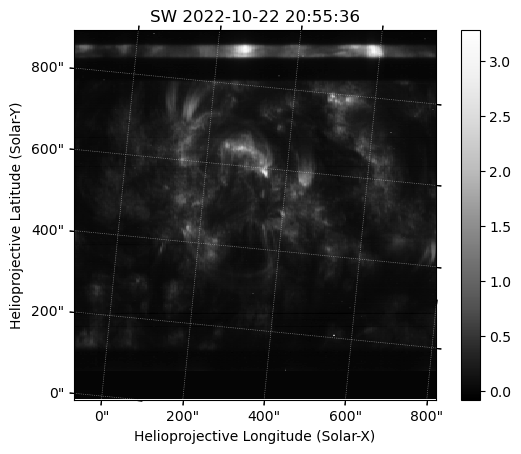

In [9]:
NeVIII_770_window_rebin_map.plot(aspect=NeVIII_770_window_rebin_map.scale.axis2/NeVIII_770_window_rebin_map.scale.axis1,
                                 cmap="Greys_r")

plt.colorbar()

In [10]:
NeVIII_770_window_wvl = spice_NeVIII_770_window.wcs.slice((0,slice(0,50),0,0)).pixel_to_world(np.arange(50)).value*1e10

In [11]:
# This exponent sets the non-gaussianity of the PSF core, 1 = Gaussian
# It also also changes its width somewhat, which is not ideal...
yl_core_xpo = 1.0

# Rotation angle of the PSF, both core and wings
psf_yl_angle = -13*np.pi/180

# FWHMs of PSF core. First argument is width along y axis before rotation,
# and is in arcseconds. Second is along lambda axis and is in angstrom.
fwhm_core0_yl = np.array([5.5, 1.15])

# This descriptor for plots should be manually edited to reflect the PSF parameters
gaussian_desc = '2-part Gaussian PSF'

fwhm_wing0_yl = np.array([20.0, 4]) # FWHMs of PSF wings in arcseconds and angstroms, respectively
desc_str='; standard wing aspect ratio'

# Fraction of overall PSF amplitude in wings (core weight is 1.0 - wing_weight).
# PSFs have unit peak amplitude, -- PLEASE NOTE: they do not integrate to 1.
wing_weight = 0.21

spice_dat1 = spice_NeVIII_770_window[0,:,200:-128,:].data.transpose([2,1,0]).astype(np.float32)

In [12]:
# read the corrected SPICE data using the code 
# spice_corr_dat, spice_corr_chi2s, metadict = correct_spice_raster(spice_dat1, spice_hdr, fwhm_core0_yl, fwhm_wing0_yl, psf_yl_angle, wing_weight,
#                                                                   super_fac=1, psf_thold_core=0.0005)

with h5py.File("../../src/SPICE/20221022/lvl3/NeVIII_770_psf_deconv_205536.h5","r") as f:
    spice_corr_dat = f['data'][:]
    spice_corr_chi2s = f['chi2s'][:]
    print(f.attrs.keys())
    det_origin0,det_dims0,det_scale0 = f.attrs['det_origin0'], f.attrs['det_dims0'], f.attrs['det_scale0']

<KeysViewHDF5 ['det_dims0', 'det_origin0', 'det_scale0', 'fwhm_core_yl', 'fwhm_symm', 'fwhm_wing_yl', 'psf_yl_angle', 'src_dims0', 'src_origin0', 'src_scale0']>


Text(0.5, 1.0, 'Corrected')

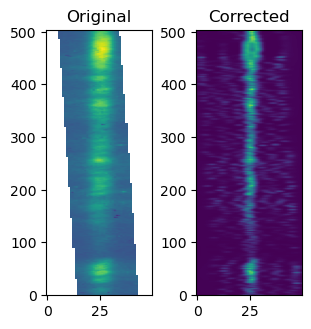

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(3,5),constrained_layout=True)

selet_column_number = 60
ax1.imshow(spice_dat1[selet_column_number,:,:],origin="lower",aspect=1/4)
ax2.imshow(spice_corr_dat[selet_column_number,:,:],origin="lower",aspect=1/4)
ax1.set_title("Original")
ax2.set_title("Corrected")


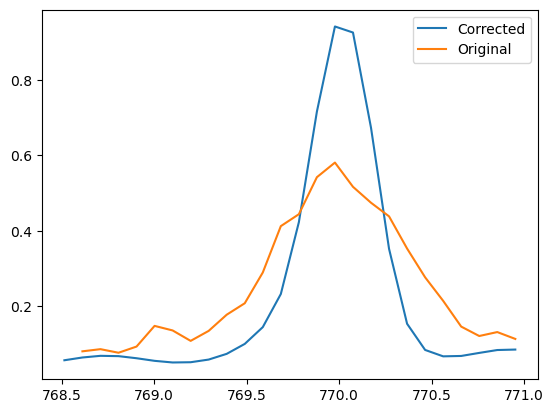

In [14]:
plt.plot(NeVIII_770_window_wvl[10:36],spice_corr_dat[100,200,10:36],label="Corrected")
plt.plot(NeVIII_770_window_wvl[10:36],spice_dat1[100,200,10:36],label="Original")
plt.legend()

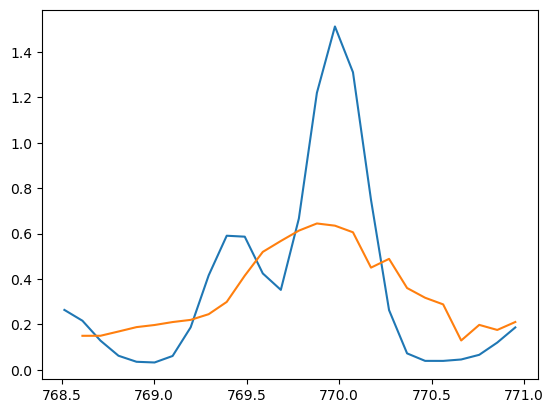

In [15]:
plt.plot(NeVIII_770_window_wvl[10:36],spice_corr_dat[60,170,10:36])
plt.plot(NeVIII_770_window_wvl[10:36],spice_dat1[60,170,10:36])

In [16]:
# Do some line fits for illustrative purposes:

spice_sdev_guess = 0.1 # Guess for standard deviation Gaussian fit to the uncorrected line profiles
corr_sdev_guess = 0.05 # Guess for standard deviation Gaussian fit to the corrected line profiles
## Estimate errors and mask off nonusable data points:
spice_err_fac = np.nanstd(spice_dat1[:,30:55,:])
spice_mask, spice_err = get_mask_errs(spice_dat1.astype(np.float64), spice_err_fac)
spice_corr_mask, spice_corr_err = get_mask_errs(spice_corr_dat, spice_err_fac)

# Wavelength scale parameters, etc for the fitting output
# spice_la = (det_origin0[2]+det_scale0[2]*np.arange(det_dims0[2]))/platescale_l
spice_la = NeVIII_770_window_wvl
spice_wlcen0 = spice_la[np.nanargmax(np.nanmean(spice_dat1[:,50:350,:],axis=(0,1)))]

# Fit the original spectra:
spice_fits = fsl(spice_dat1, spice_err, spice_la, spice_mask, spice_wlcen0, spice_sdev_guess)

# Fit the corrected spectra:
spice_corr_fits = fsl(spice_corr_dat, spice_corr_err, spice_la, spice_corr_mask, spice_wlcen0, spice_sdev_guess)

/home/yjzhu/Solar/spice_psf/spice_psf/util.py:37: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_masked_medfilt_inner" failed type inference due to: Use of unsupported NumPy function 'numpy.unravel_index' or unsupported use of the function.

File "../../../spice_psf/spice_psf/util.py", line 40:
def _masked_medfilt_inner(flatinds,data,footprint_inds,footprint_ind_offset,tparg,dat_pad_shape,data_fppad,mask_fppad,data_filt):
    <source elided>
    for ind in flatinds:
        ijkpad = np.unravel_index(ind,data.shape)+footprint_inds-footprint_ind_offset
        ^

During: typing of get attribute at /home/yjzhu/Solar/spice_psf/spice_psf/util.py (40)

File "../../../spice_psf/spice_psf/util.py", line 40:
def _masked_medfilt_inner(flatinds,data,footprint_inds,footprint_ind_offset,tparg,dat_pad_shape,data_fppad,mask_fppad,data_filt):
    <source elided>
    for ind in flatinds:
        ijkpad = np.unravel_index(ind,data.shape)+footprint_i

0 of 224 0.0
11 of 224 0.0
22 of 224 0.0
33 of 224 0.0
44 of 224 0.0
55 of 224 0.0
66 of 224 0.0
77 of 224 0.0
88 of 224 0.0
99 of 224 0.0
110 of 224 0.0
121 of 224 0.0
132 of 224 0.0
143 of 224 0.0
154 of 224 0.0
165 of 224 0.0
176 of 224 0.0
187 of 224 0.0
198 of 224 0.0
209 of 224 0.0
220 of 224 0.0
223 of 224 0.0
0 of 224 0.0
11 of 224 0.0
22 of 224 0.0
33 of 224 0.0
44 of 224 0.0
55 of 224 0.0
66 of 224 0.0
77 of 224 0.0
88 of 224 0.0
99 of 224 0.0
110 of 224 0.0
121 of 224 0.0
132 of 224 0.0
143 of 224 0.0
154 of 224 0.0
165 of 224 0.0
176 of 224 0.0
187 of 224 0.0
198 of 224 0.0
209 of 224 0.0
220 of 224 0.0
223 of 224 0.0


In [17]:
spice_origin_vel = spice_fits["centers"].T/spice_wlcen0*const.c.to_value("km/s")
spice_origin_vel = spice_origin_vel - np.nanmedian(spice_origin_vel)

spice_corr_vel = spice_corr_fits["centers"].T/spice_wlcen0*const.c.to_value("km/s")
spice_corr_vel = spice_corr_vel - np.nanmedian(spice_corr_vel)

In [19]:
spice_fits.keys()

dict_keys(['centers', 'amplitudes', 'sigmas', 'continuum', 'chi2'])

Text(0.5, 1.0, 'Corrected')

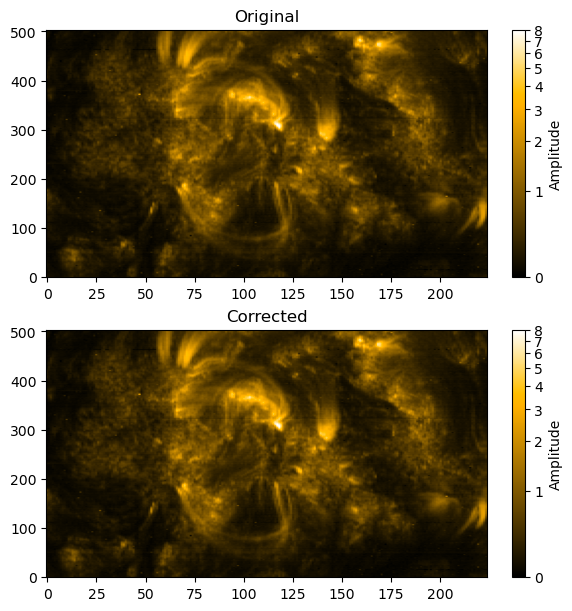

In [24]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,6),constrained_layout=True)

int_norm = ImageNormalize(vmin=0,vmax=8,stretch=AsinhStretch(0.1))

ax1.imshow(spice_fits['amplitudes'].T,origin="lower",aspect=1/4,cmap="sdoaia171",norm=int_norm)
plt.colorbar(ax1.images[0],ax=ax1,label="Amplitude")
ax1.set_title("Original")

ax2.imshow(spice_fits['amplitudes'].T,origin="lower",aspect=1/4,cmap="sdoaia171",norm=int_norm)
plt.colorbar(ax2.images[0],ax=ax2,label="Amplitude")
ax2.set_title("Corrected")


Text(0.5, 1.0, 'Corrected')

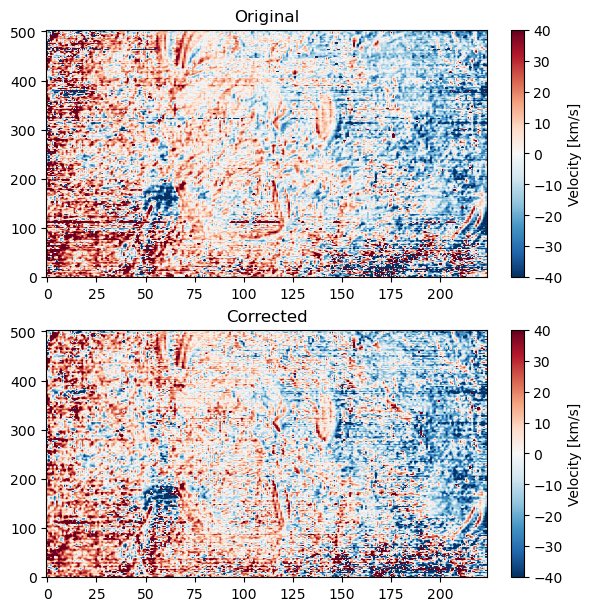

In [22]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,6),constrained_layout=True)

ax1.imshow(spice_origin_vel,origin="lower",aspect=1/4,vmin=-40,vmax=40,cmap="RdBu_r")
plt.colorbar(ax1.images[0],ax=ax1,label="Velocity [km/s]")
ax1.set_title("Original")

ax2.imshow(spice_corr_vel,origin="lower",aspect=1/4,vmin=-40,vmax=40,cmap="RdBu_r")
plt.colorbar(ax2.images[0],ax=ax2,label="Velocity [km/s]")
ax2.set_title("Corrected")
